In [1]:
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

from sklearn.utils import check_random_state

# implementing OPE of the IPWLearner using synthetic bandit data
from sklearn.linear_model import LogisticRegression, LinearRegression

import matplotlib.pyplot as plt

from scipy.special import softmax
from abc import ABCMeta

# import open bandit pipeline (obp)
# from obp.dataset import OpenBanditDataset
# from obp.dataset import linear_reward_function, logistic_reward_function


from obp.ope import (
    # OffPolicyEvaluation,
    RegressionModel,
    # InverseProbabilityWeighting as IPW,
    DirectMethod as DM,
    # DoublyRobust as DR,
    # SelfNormalizedDoublyRobust as SNDR
)

from my_utils import (
    eval_policy,
    CFModel,
    CustomCFDataset,
    NeighborhoodModel
    # create_simluation_data_from_pi,
    # sample_policy_actions
)
random_state=12345
random_ = check_random_state(random_state)

In [2]:
def calc_reward(dataset, policy):
    return np.array([np.sum(dataset['q_x_a'] * policy.squeeze(), axis=1).mean()])

In [3]:
pd.options.display.float_format = '{:,.4f}'.format

In [4]:
def generate_dataset(params):
    emb_a = random_.normal(size=(params["n_actions"], params["emb_dim"]))
    noise_a = random_.normal(size=(params["emb_dim"]))
    our_a = (1-params["eps"]) * emb_a + params["eps"] * noise_a

    original_a = our_a.copy()

    emb_x = random_.normal(size=(params["n_users"], params["emb_dim"]))
    noise_x = random_.normal(size=(params["emb_dim"])) 
    our_x = (1-params["eps"]) * emb_x + params["eps"] * noise_x
    original_x = our_x.copy()

    score = emb_x @ emb_a.T
    # score = random_.normal(score, scale=params["sigma"])
    q_x_a = (1 / (5.0 + np.exp(-score)))

    return dict(
                emb_a=emb_a,
                our_a=our_a,
                original_a=original_a,
                emb_x=emb_x,
                our_x=our_x,
                original_x=original_x,
                q_x_a=q_x_a,
                n_actions=params["n_actions"],
                n_users=params["n_users"],
                emb_dim=params["emb_dim"]
                )

In [46]:
def create_simluation_data_from_pi(pi: np.ndarray, q_x_a: np.ndarray, n_users: np.int, n_actions: np.int, random_state: int = 12345):
    random_ = check_random_state(random_state)
    simulation_data = {'actions':np.zeros((n_actions, n_users), dtype=np.int32), 
                       'users': np.zeros((n_actions, n_users), dtype=np.int32), 
                       'reward':np.zeros((n_actions, n_users)),
                       'pscore':np.zeros((n_actions, n_users))}
    
    reward = q_x_a  > random_.random(size=q_x_a.shape)
    simulation_data['pi_0'] = pi
    actions = []
    for i in range(n_users):
        user_actions = random_.choice(np.arange(n_actions), size=n_actions, p=pi[i], replace=True)
        actions.append(np.array(user_actions))

    actions = np.vstack(actions)
    for i in range(n_actions):
        simulation_data['actions'][i] = actions[:, i]
        simulation_data['users'][i] = np.arange(n_users)
        qq = q_x_a[np.arange(n_users), simulation_data['actions'][i]]
        simulation_data['reward'][i] = np.squeeze(qq > random_.random(size=qq.shape))
        simulation_data['pscore'][i] = np.squeeze(pi[np.arange(n_users), simulation_data['actions'][i]])
    
    simulation_data['q_x_a'] = reward
    return simulation_data

In [6]:
def get_test_data(dataset, simulation_data, n_test_data):
    return dict(
        num_data=n_test_data*dataset["n_users"],
        num_actions=dataset["n_actions"],
        x=dataset["our_x"][simulation_data['users'][:n_test_data].flatten()],
        a=simulation_data['actions'][:n_test_data].flatten(),
        r=simulation_data['reward'][:n_test_data].flatten(),
        x_idx=simulation_data['users'][:n_test_data].flatten(),
        pi_0=simulation_data['pi_0'],
        pscore=simulation_data['pscore'][:n_test_data].flatten(),
        q_x_a=simulation_data['q_x_a'],
    )

In [7]:
def get_train_data(n_actions, train_size, sim_data, idx, emb_x):
   return dict(
                num_data=train_size,
                num_actions=n_actions,
                x=emb_x[sim_data['users'][idx].flatten()],
                a=sim_data['actions'][idx].flatten(),
                r=sim_data['reward'][idx].flatten(),
                x_idx=sim_data['users'][idx].flatten(),
                pi_0=sim_data['pi_0'],
                pscore=sim_data['pscore'][idx].flatten(),
                q_x_a=sim_data['q_x_a']
                )

In [8]:
class IPWPolicyLoss(nn.Module):
    def __init__(self, log_eps=1e-10):
        super(IPWPolicyLoss, self).__init__()
        self.log_eps = log_eps

    def forward(self, pscore, scores, policy_prob, original_policy_rewards, original_policy_actions):
        n = original_policy_actions.shape[0]

        pi_e_at_position = policy_prob[torch.arange(n), original_policy_actions].squeeze()
        iw = pi_e_at_position / pscore
        iw = iw.detach()
        # q_hat_at_position = scores[torch.arange(n), original_policy_actions].squeeze()
        # dm_grads = (scores * policy_prob.detach() * torch.log(policy_prob)).sum(dim=1)
        log_pi = torch.log(pi_e_at_position).squeeze()
        
        # reinforce trick step
        # reinforce_grad = ((iw * (original_policy_rewards - q_hat_at_position) * log_pi) / iw.sum()) + dm_grads
        reinforce_grad = iw * original_policy_rewards * log_pi
        
        return -reinforce_grad.mean()

In [9]:
class SNDRPolicyLoss(nn.Module):
    def __init__(self, log_eps=1e-10):
        super(IPWPolicyLoss, self).__init__()
        self.log_eps = log_eps

    def forward(self, pscore, scores, policy_prob, original_policy_rewards, original_policy_actions):
        n = original_policy_actions.shape[0]

        pi_e_at_position = policy_prob[torch.arange(n), original_policy_actions].squeeze()
        iw = pi_e_at_position / pscore
        iw = iw.detach()
        q_hat_at_position = scores[torch.arange(n), original_policy_actions].squeeze()
        dm_reward = (scores * policy_prob.detach()).sum(dim=1)
        log_pi = torch.log(pi_e_at_position).squeeze()
        
        # reinforce trick step
        r_hat = ((iw * (original_policy_rewards - q_hat_at_position)) / iw.sum()) + dm_reward
        reinforce_grad = r_hat * log_pi
        return -reinforce_grad.mean()

In [10]:
def get_ope_results_dict(reg_results, conv_results):
    reward = conv_results[:, 0]
    return dict(
                policy_rewards=reward.mean(),
                ipw=np.mean(abs(conv_results[: ,3] - reward)),
                reg_dm=np.mean(abs(reg_results - reward)),
                conv_dm=np.mean(abs(conv_results[: ,1] - reward)),
                conv_dr=np.mean(abs(conv_results[: ,2] - reward)),
                conv_sndr=np.mean(abs(conv_results[: ,4] - reward)),
                
                ipw_var=np.std(conv_results[: ,3]),
                reg_dm_var=np.std(reg_results),
                conv_dm_var=np.std(conv_results[: ,1]),
                conv_dr_var=np.std(conv_results[: ,2]),
                conv_sndr_var=np.std(conv_results[: ,4]),
                )

In [11]:
def get_opl_results_dict(reg_results, conv_results):
    reward = conv_results[:, 0]
    return    dict(
                policy_rewards=np.mean(reward),
                ipw=np.mean(abs(conv_results[: ,3] - reward)),
                reg_dm=np.mean(abs(reg_results - reward)),
                conv_dm=np.mean(abs(conv_results[: ,1] - reward)),
                conv_dr=np.mean(abs(conv_results[: ,2] - reward)),
                conv_sndr=np.mean(abs(conv_results[: ,4] - reward)),
                # ipw_var=np.var(conv_results[: ,3]),
                # reg_dm_var=np.var(reg_results),
                # conv_dm_var=np.var(conv_results[: ,1]),
                # conv_dr_var=np.var(conv_results[: ,2]),
                # conv_sndr_var=np.var(conv_results[: ,4]),
                action_diff_to_real=np.mean(conv_results[: ,5]),
                action_delta=np.mean(conv_results[: ,6]),
                context_diff_to_real=np.mean(conv_results[: ,7]),
                context_delta=np.mean(conv_results[: ,8])
                )

In [12]:
result_path = Path(f"./result/{datetime.now().strftime('%Y-%m-%d')}/train_data")
result_path.mkdir(parents=True, exist_ok=True)
result_file_name = f"result_{datetime.now().strftime('%H:00')}.csv"
curve_file_name = f"curve_{datetime.now().strftime('%H:00')}.csv"
print(result_file_name)

result_09:00.csv


## OPE

We will run several simulations on a generated dataset, the dataset is generated like this:
$$ \text{We have users U and actions A } u_i \sim N(0, I_{emb_dim}) \ a_i \sim N(0, I_{emb_dim})$$
$$ p_{ij} = 1 / (5 + e^{-(u_i.T a_j)}) $$
$$r_{ij} \sim Bin(p_{ij})$$

We have a policy $\pi$
and it's ground truth reward is calculated by
$$R_{gt} = \sum_{i}{\sum_{j}{\pi_{ij} * p_{ij}}} $$

In [13]:
def no_learning_trial(
                      num_runs, 
                      num_neighbors, 
                      num_rounds_list, 
                      dataset
                      ):
    results = {}
    dm = DM()
    our_x, our_a, n_actions = dataset["our_x"], dataset["our_a"], dataset["n_actions"]

    for train_size in num_rounds_list:
        reg_results, conv_results = [], []
        for run in range(num_runs):
            
            greedy = np.ones_like(dataset["q_x_a"])/(dataset["n_actions"])
            pi_0 = softmax(our_x @ our_a.T, axis=1)

            pi_0 = 0.8 * pi_0 + 0.2 * greedy
            simulation_data = create_simluation_data_from_pi(
                                                            pi_0,
                                                            dataset["q_x_a"],
                                                            dataset["n_users"],
                                                            dataset["n_actions"],
                                                            random_state=train_size*(run+1)
                                                            )
            
            # test_data = get_test_data(dataset, simulation_data, n_test_data)
            
            # idx = np.arange(train_size) + n_test_data
            idx = np.arange(train_size)
            train_data = get_train_data(n_actions, train_size, simulation_data, idx, our_x)
            
            regression_model = RegressionModel(
                                                n_actions=n_actions,
                                                action_context=our_x,
                                                base_model=LogisticRegression(random_state=12345)
                                                )
            
            neighberhoodmodel = NeighborhoodModel(
                                                    train_data['x_idx'],
                                                    train_data['a'], 
                                                    our_a,
                                                    our_x, 
                                                    train_data['r'], 
                                                    num_neighbors=num_neighbors
                                                )
            
            original_policy_prob = np.expand_dims(pi_0, -1)
            regression_model.fit(train_data['x'], train_data['a'], train_data['r'], original_policy_prob[train_data['x_idx'], train_data['a']].squeeze())
            policy = np.expand_dims(softmax(our_x @ our_a.T, axis=1), -1)

            # reg_dm = dm.estimate_policy_value(policy[test_data['x_idx']], regression_model.predict(test_data['x']))
            reg_dm = dm.estimate_policy_value(policy[train_data['x_idx']], regression_model.predict(train_data['x']))

            reg_results.append(reg_dm)

            # conv_results.append(eval_policy(neighberhoodmodel, test_data, original_policy_prob[test_data['x_idx']], policy))
            conv_results.append(eval_policy(neighberhoodmodel, train_data, original_policy_prob[train_data['x_idx']], policy))
            conv_results[-1] = np.append(calc_reward(dataset, policy), conv_results[-1])

        reg_results = np.array(reg_results)
        conv_results = np.array(conv_results)

        results[train_size] = get_ope_results_dict(reg_results, conv_results)
        
    return pd.DataFrame.from_dict(results, orient='index')

In [41]:
n_test_data = 5

dataset_params = dict(
                    n_actions= 150,
                    n_users = 150,
                    emb_dim = 5,
                    # sigma = 0.1,
                    eps = 0.2
                    )

dataset = generate_dataset(dataset_params)

# num_rounds_list = [3]
num_rounds_list = [1, 2, 3, 4, 5, 10, 20]

# num_runs = 5 # number of simulations
max_iter = 25 # number of epochs

In [42]:
# dm = DM()
# results = {}
num_runs = 10
batch_size = 50
num_neighbors = 6
# num_rounds_list = [3, 5]

We start with the parameters:
$$EmbDim = 5$$
$$NumActions= 150$$
$$NumUsers = 150$$
$$NeighborhoodSize = 6$$
and we run 10 trials for stability and variance calculation


To test the policy $\pi$
We will use an initial policy : $$\pi_{start} = (1-\epsilon)*\pi + \epsilon * greedy$$ to sample examples from the data
and then use ope tools and the convolution model to calculate $\hat{R}$

#### Initial Noised Policy
This is the first policy we will test out, the policy is:

$$emb = 0.8 * gt + 0.2 * noise$$

In [43]:
df1 = no_learning_trial(num_runs, num_neighbors, num_rounds_list, dataset)

In [44]:
df1

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,ipw_var,reg_dm_var,conv_dm_var,conv_dr_var,conv_sndr_var
1,0.1866,0.1172,0.0255,0.0301,0.0320,0.0374,0.0139,0.0331,0.0361,0.0358,0.0396
2,0.1866,0.1136,0.0159,0.0227,0.0211,0.0234,0.0104,0.0212,0.0278,0.0256,0.0281
3,0.1866,0.1172,0.0124,0.0111,0.0100,0.0121,0.0076,0.0129,0.0127,0.0106,0.0145
4,0.1866,0.1205,0.0157,0.0145,0.0164,0.0208,0.0106,0.0163,0.0192,0.0207,0.0262
5,0.1866,0.1201,0.0146,0.0153,0.0156,0.0185,0.0113,0.0189,0.0196,0.0203,0.0232
10,0.1866,0.1173,0.0117,0.0079,0.0073,0.0074,0.0049,0.0124,0.0117,0.0116,0.0124
20,0.1866,0.1170,0.0087,0.0063,0.0058,0.0069,0.0053,0.0054,0.0081,0.0078,0.0086


<Axes: title={'center': 'IPW vs DM vs DR vs SNDR Errors'}>

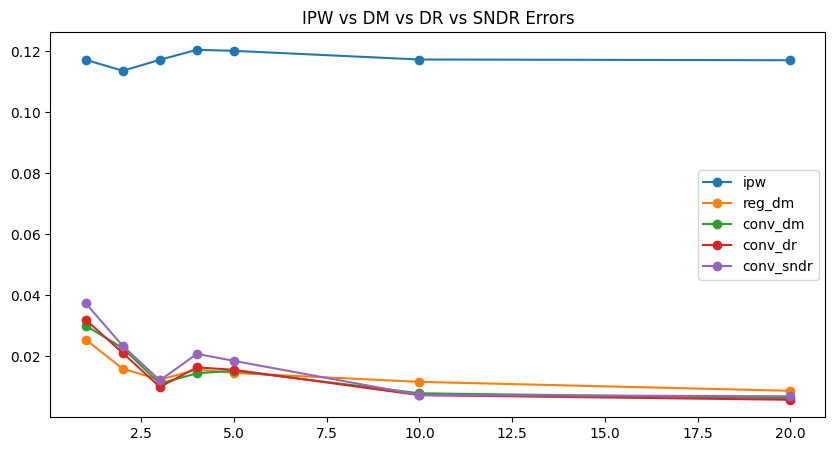

In [45]:
df1.plot(
    y=["ipw", "reg_dm", "conv_dm", "conv_dr", "conv_sndr"],
    title="IPW vs DM vs DR vs SNDR Errors",
    figsize=(10, 5),
    marker="o",
)

#### Optimal policy

$$emb = gt

In [19]:
temp_data = dataset.copy()
temp_data['our_a'] = dataset["emb_a"]
temp_data['our_x'] = dataset["emb_x"]

In [20]:
df2 = no_learning_trial(num_runs, num_neighbors, num_rounds_list, temp_data)

In [21]:
df2

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,ipw_var,reg_dm_var,conv_dm_var,conv_dr_var,conv_sndr_var
1,0.1940,0.1093,0.0359,0.0375,0.0400,0.0430,0.0211,0.0398,0.0431,0.0442,0.0498
2,0.1940,0.1138,0.0305,0.0301,0.0268,0.0302,0.0153,0.0316,0.0345,0.0313,0.0289
3,0.1940,0.1067,0.0208,0.0175,0.0157,0.0188,0.0133,0.0224,0.0215,0.0208,0.0230
4,0.1940,0.1121,0.0253,0.0235,0.0249,0.0263,0.0155,0.0173,0.0207,0.0210,0.0233
5,0.1940,0.1088,0.0201,0.0179,0.0214,0.0259,0.0131,0.0186,0.0218,0.0242,0.0290


<Axes: title={'center': 'IPW vs DM vs DR vs SNDR Errors'}>

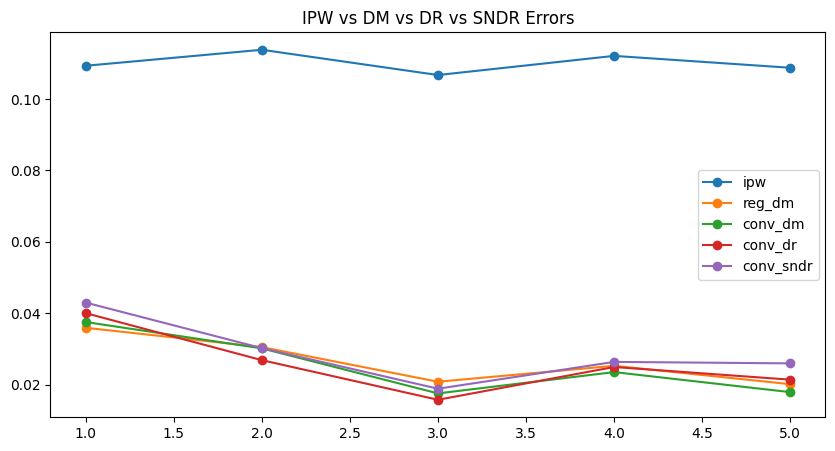

In [22]:
df2.plot(
    y=["ipw", "reg_dm", "conv_dm", "conv_dr", "conv_sndr"],
    title="IPW vs DM vs DR vs SNDR Errors",
    figsize=(10, 5),
    marker="o",
)

#### Random Policy

$$emb = noise$$

In [23]:
new_x = random_.normal(size=(dataset_params["n_users"], dataset_params["emb_dim"]))
new_a = random_.normal(size=(dataset_params["n_actions"], dataset_params["emb_dim"]))

temp_data['our_a'] = new_a
temp_data['our_x'] = new_x

In [24]:
df3 = no_learning_trial(num_runs, num_neighbors, num_rounds_list, temp_data)

In [25]:
df3

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,ipw_var,reg_dm_var,conv_dm_var,conv_dr_var,conv_sndr_var
1,0.1439,0.0785,0.0190,0.0186,0.0165,0.0194,0.0100,0.0204,0.0223,0.0195,0.0221
2,0.1439,0.0689,0.0194,0.0251,0.0255,0.0290,0.0147,0.0198,0.0262,0.0261,0.0280
3,0.1439,0.0794,0.0087,0.0156,0.0167,0.0184,0.0111,0.0107,0.0179,0.0188,0.0207
4,0.1439,0.0743,0.0110,0.0177,0.0165,0.0150,0.0105,0.0122,0.0169,0.0150,0.0145
5,0.1439,0.0799,0.0098,0.0095,0.0096,0.0104,0.0123,0.0110,0.0100,0.0106,0.0133


<Axes: title={'center': 'IPW vs DM vs DR vs SNDR Errors'}>

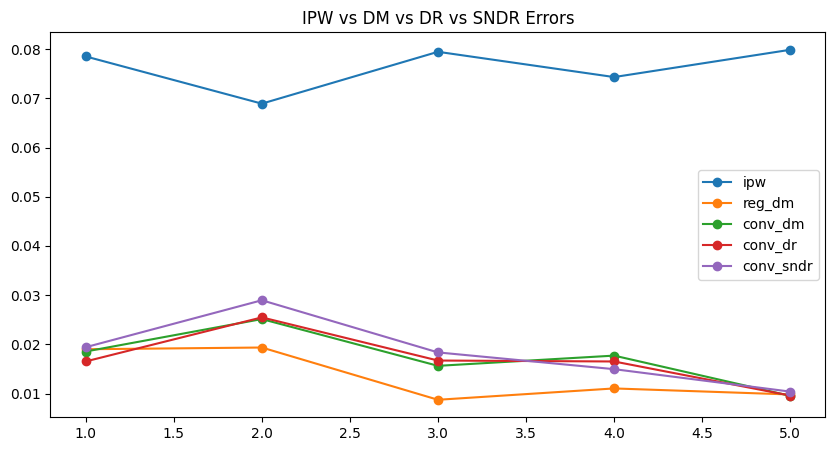

In [26]:
df3.plot(
    y=["ipw", "reg_dm", "conv_dm", "conv_dr", "conv_sndr"],
    title="IPW vs DM vs DR vs SNDR Errors",
    figsize=(10, 5),
    marker="o",
)

#### Iterative improvement
At each iteration the model embeddings get closer to the ground truth - $$emb = (1-\epsilon_t) * gt + \epsilon_t * noise$$

In [27]:
df_iterative_improvment = df3.copy()
df_iterative_improvment['noise level'] = 10

for i in range(1, 11):
    temp_data['our_a'] = ((10-i) * new_a + i * dataset["emb_a"]) /10
    temp_data['our_x'] = ((10-i) * new_x + i * dataset["emb_x"]) /10

    rounds = [num_rounds_list[-1]]
    df = no_learning_trial(num_runs, num_neighbors, rounds, temp_data)
    df['noise level'] = 10 - i
    df_iterative_improvment = pd.concat([df_iterative_improvment, df])

In [28]:
keys_for_display = ['noise level', 'policy_rewards', 
                    'ipw', 'reg_dm', 'conv_dm', 'conv_dr', 'conv_sndr',
                    'ipw_var', 'reg_dm_var', 'conv_dm_var', 'conv_dr_var', 'conv_sndr_var']

In [29]:
df_iterative_improvment.iloc[4:][keys_for_display]

,noise level,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,ipw_var,reg_dm_var,conv_dm_var,conv_dr_var,conv_sndr_var
5,10,0.1439,0.0799,0.0098,0.0095,0.0096,0.0104,0.0123,0.0110,0.0100,0.0106,0.0133
5,9,0.1445,0.0857,0.0111,0.0125,0.0133,0.0163,0.0098,0.0125,0.0137,0.0158,0.0220
5,8,0.1474,0.0929,0.0115,0.0115,0.0144,0.0212,0.0092,0.0123,0.0144,0.0171,0.0237
5,7,0.1525,0.1016,0.0116,0.0126,0.0117,0.0128,0.0067,0.0103,0.0136,0.0129,0.0137
5,6,0.1592,0.1073,0.0163,0.0163,0.0167,0.0176,0.0081,0.0146,0.0178,0.0165,0.0157
5,5,0.1667,0.1122,0.0144,0.0141,0.0132,0.0140,0.0069,0.0141,0.0146,0.0147,0.0175
5,4,0.1743,0.1162,0.0095,0.0097,0.0095,0.0094,0.0054,0.0090,0.0117,0.0107,0.0100
5,3,0.1813,0.1210,0.0146,0.0106,0.0111,0.0136,0.0065,0.0115,0.0117,0.0121,0.0142
5,2,0.1870,0.1209,0.0147,0.0109,0.0122,0.0151,0.0069,0.0126,0.0116,0.0134,0.0178
5,1,0.1912,0.1208,0.0182,0.0167,0.0181,0.0215,0.0083,0.0107,0.0153,0.0171,0.0219


In [39]:
dfplot = df_iterative_improvment.iloc[4:]
dfplot.set_index('noise level', inplace=True)

<Axes: title={'center': 'IPW vs DM vs DR vs SNDR Errors'}, xlabel='noise level'>

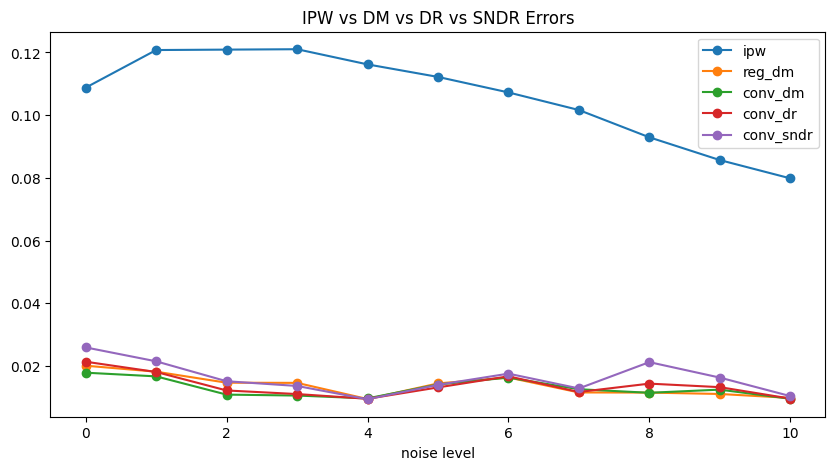

In [40]:
dfplot.plot(
    y=["ipw", "reg_dm", "conv_dm", "conv_dr", "conv_sndr"],
    title="IPW vs DM vs DR vs SNDR Errors",
    figsize=(10, 5),
    marker="o",
)

Bigger Dataset

In [ ]:
# n_test_data = 5

# new_dataset_params = dict(
#                     n_actions= 300,
#                     n_users = 300,
#                     emb_dim = 5,
#                     sigma = 0.1,
#                     eps = 0.4
#                     )

# new_dataset = generate_dataset(new_dataset_params)

# num_rounds_list = [3, 6, 10, 15, 20]
# num_runs = 2 # number of simulations
# max_iter = 25 # number of epochs

In [ ]:
# no_learning_trial(num_runs, num_neighbors, rounds, new_dataset)

## Learning

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [ ]:
# num_runs = 3
num_runs = 1

In [ ]:
# 4. Define the training function
def train(model, train_loader, neighborhood_model, num_epochs=1, lr=0.0001):

    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr) # here we can change the learning rate
    criterion = IPWPolicyLoss()

    model.train() # Set the model to training mode
    tq = tqdm(range(num_epochs))
    for epoch in tq:
        running_loss = 0.0
        total_samples = 0
        
        for user_idx, action_idx, rewards, original_prob in train_loader:
            # Move data to GPU if available
            if torch.cuda.is_available():
                user_idx = user_idx.to(device) 
                action_idx = action_idx.to(device)
                rewards = rewards.to(device)
                original_prob = original_prob.to(device) 
            
            # Forward pass
            policy = model(user_idx)
            pscore = original_prob[torch.arange(user_idx.shape[0]), action_idx.type(torch.long)]
            
            scores = torch.tensor(neighborhood_model.predict(user_idx.cpu().numpy()))
            
            loss = criterion(
                              pscore,
                              scores,
                              policy, 
                              rewards, 
                              action_idx.type(torch.long), 
                              )
            
            # Zero the gradients Backward pass and optimization
            optimizer.zero_grad()

            loss.backward()       
            optimizer.step()
            
            # update neighborhood
            # action_emb, context_emb = model.get_params()
            
            # Calculate running loss and accuracy
            running_loss += loss.item()
            total_samples += 1

            # Print statistics after each epoch
            epoch_loss = running_loss / total_samples
            tq.set_description(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
            
        # neighborhood_model.update(action_emb.detach().numpy(), context_emb.detach().numpy())


In [ ]:
def trainer_trial(
                  num_runs,
                  num_neighbors,
                  num_rounds_list,
                  dataset,
                  batch_size,
                  num_epochs,
                  lr=0.001
                  ):
    dm = DM()
    results = {}

    our_x, our_a = dataset["our_x"], dataset["our_a"]
    emb_x, emb_a = dataset["emb_x"], dataset["emb_a"]
    
    original_x, original_a = dataset["original_x"], dataset["original_a"]
    n_users, n_actions, emb_dim = dataset["n_users"], dataset["n_actions"], dataset["emb_dim"]

    for train_size in num_rounds_list:
        reg_results, conv_results = [], []
        for run in range(num_runs):

            pi_0 = np.ones_like(dataset["q_x_a"])/(dataset["n_actions"])
            original_policy_prob = np.expand_dims(pi_0, -1)
            simulation_data = create_simluation_data_from_pi(
                                                            pi_0,
                                                            dataset["q_x_a"],
                                                            dataset["n_users"],
                                                            dataset["n_actions"],
                                                            random_state=train_size*(run+1)
                                                            )
            
            # test_data = get_test_data(dataset, simulation_data, n_test_data)
            
            # idx = np.arange(train_size) + n_test_data
            idx = np.arange(train_size)
            train_data = get_train_data(n_actions, train_size, simulation_data, idx, our_x)
            
            regression_model = RegressionModel(
                                                n_actions=n_actions,
                                                action_context=our_x,
                                                base_model=LogisticRegression(random_state=12345)
                                                )
            
            regression_model.fit(train_data['x'], 
                        train_data['a'],
                        train_data['r'],
                        original_policy_prob[train_data['x_idx'],
                        train_data['a']].squeeze()
                        )

            neighberhoodmodel = NeighborhoodModel(
                                                    train_data['x_idx'],
                                                    train_data['a'], 
                                                    our_a,
                                                    our_x, 
                                                    train_data['r'], 
                                                    num_neighbors=num_neighbors
                                                )
            

            model = CFModel(
                            n_users, 
                            n_actions, 
                            emb_dim, 
                            initial_user_embeddings=torch.tensor(our_x), 
                            initial_actions_embeddings=torch.tensor(our_a)
                            )
            
            cf_dataset =  CustomCFDataset(
                                       train_data['x_idx'], 
                                       train_data['a'], 
                                       train_data['r'], 
                                       original_policy_prob[train_data['x_idx']]
                                       )
            
            train_loader = DataLoader(cf_dataset, batch_size=batch_size, shuffle=False)
            
            train(model, train_loader, neighberhoodmodel, num_epochs=num_epochs, lr=lr)

            our_a, our_x = model.get_params()
            our_a, our_x = our_a.detach().cpu().numpy(), our_x.detach().cpu().numpy()

            policy = np.expand_dims(softmax(our_x @ our_a.T, axis=1), -1)

            # reg_dm = dm.estimate_policy_value(policy[test_data['x_idx']], regression_model.predict(test_data['x']))
            reg_dm = dm.estimate_policy_value(policy[train_data['x_idx']], regression_model.predict(train_data['x']))

            reg_results.append(reg_dm)

            # conv_results.append(eval_policy(neighberhoodmodel, test_data, original_policy_prob[test_data['x_idx']], policy))
            conv_results.append(calc_reward(dataset, policy))
            conv_results.append(eval_policy(neighberhoodmodel, train_data, original_policy_prob[train_data['x_idx']], policy))

            conv_results[-1] = np.append(conv_results[-1], [np.mean(np.abs(emb_a-our_a)), np.mean(np.abs(original_a-our_a))])
            conv_results[-1] = np.append(conv_results[-1], [np.mean(np.abs(emb_x-our_x)), np.mean(np.abs(original_x-our_x))])
            
            our_a, our_x = original_a.copy(), original_x.copy()

        reg_results = np.array(reg_results)
        conv_results = np.array(conv_results)

        results[train_size] = get_opl_results_dict(reg_results, conv_results)
    
    return pd.DataFrame.from_dict(results, orient='index')

In [ ]:
num_runs = 1

Regular Reinforce grad (iw * log_p * R)

In [ ]:
df4 = trainer_trial(num_runs, num_neighbors, num_rounds_list, dataset, batch_size+100, num_epochs=1, lr=0.005)

Epoch [1/1], Loss: 0.7251: 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
df4

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
3,0.2400,0.0626,0.0849,0.0567,0.0745,0.0763,0.1836,0.0100,0.3027,0.0028
6,0.2333,0.0452,0.0960,0.0622,0.0069,0.0135,0.1871,0.0162,0.3026,0.0056
10,0.1933,0.0006,0.0398,0.0091,0.0017,0.0014,0.1918,0.0226,0.3019,0.0103
15,0.1667,0.0242,0.0242,0.0036,0.0182,0.0171,0.1988,0.0275,0.3030,0.0142
20,0.2467,0.0010,0.1017,0.0462,0.0241,0.0250,0.1999,0.0326,0.3037,0.0183


Less epochs, different lr

In [ ]:
df5 = trainer_trial(num_runs, num_neighbors, num_rounds_list, dataset, batch_size, num_epochs=5, lr=0.001)

Epoch [5/5], Loss: 0.9169: 100%|██████████| 5/5 [00:01<00:00,  3.59it/s]


In [ ]:
df5

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
3,0.2600,0.0717,0.1047,0.0760,0.0887,0.0898,0.1870,0.0179,0.3029,0.0057
6,0.2200,0.0810,0.0827,0.0479,0.0224,0.0130,0.1917,0.0271,0.3028,0.0106
10,0.2133,0.0026,0.0598,0.0276,0.0043,0.0055,0.2008,0.0372,0.3024,0.0205
15,0.1733,0.0405,0.0308,0.0080,0.0283,0.0257,0.2062,0.0425,0.3034,0.0274
20,0.2733,0.0038,0.1282,0.0696,0.0298,0.0323,0.2080,0.0476,0.3054,0.0345


In [ ]:
df6 = trainer_trial(num_runs, num_neighbors, num_rounds_list, dataset, batch_size, num_epochs=10, lr=0.003)

Epoch [10/10], Loss: 1.4875: 100%|██████████| 10/10 [00:02<00:00,  3.44it/s]


In [ ]:
df6

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
3,0.2467,0.0919,0.0881,0.0556,0.0069,0.0024,0.2405,0.1137,0.3063,0.0367
6,0.3200,0.3843,0.1829,0.1359,0.2018,0.0828,0.2852,0.1767,0.3115,0.0708
10,0.2733,0.3203,0.1199,0.0700,0.1959,0.1123,0.3470,0.2358,0.3204,0.1361
15,0.2800,0.3740,0.1371,0.0902,0.2344,0.1255,0.3689,0.2567,0.3321,0.1853
20,0.3600,0.3821,0.2134,0.1303,0.2042,0.0969,0.3737,0.2694,0.3630,0.2223


In [ ]:
df7 = trainer_trial(num_runs, num_neighbors, num_rounds_list[:-3], dataset, batch_size+100, num_epochs=10, lr=0.003)

Epoch [10/10], Loss: 1.1704: 100%|██████████| 10/10 [00:00<00:00, 17.29it/s]


In [ ]:
df7

,policy_rewards,ipw,reg_dm,conv_dm,conv_dr,conv_sndr,action_diff_to_real,action_delta,context_diff_to_real,context_delta
3,0.2533,0.0091,0.0968,0.0667,0.0514,0.0512,0.2026,0.0575,0.3042,0.0205
6,0.2467,0.1899,0.1095,0.0699,0.0890,0.0536,0.2231,0.0898,0.3053,0.0393


In [ ]:
df['getting closer to real emb'] = df['diff_to_real'].max() - df['diff_to_real']

KeyError: 'diff_to_real'

<Axes: >

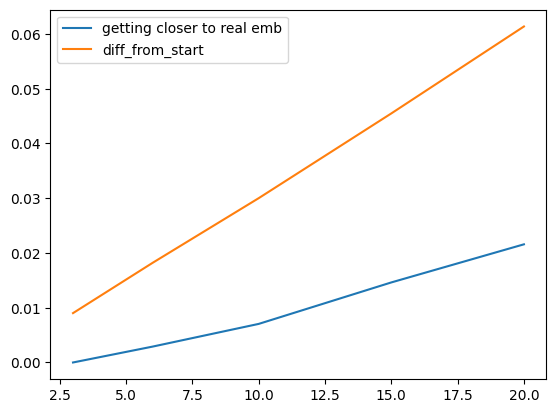

In [ ]:
df.plot(y=['getting closer to real emb', 'diff_from_start'])